In [1]:
import networkx as nx
import pandas as pd
from community import community_louvain

In [6]:
import pandas as pd

# Define data types for columns. This is an example; adjust according to your data.
column_types = {'Column1': 'float64', 'Column3': 'str', 'Column5': 'str', 'Column12': 'str', 'Column24': 'str'}

#df = pd.read_csv('X-IIoTID.csv', dtype=column_types)
df = pd.read_csv('X-IIoTID.csv', low_memory=False)
pd.set_option('display.max_columns', None)
print(df.head())

         Date   Timestamp         Scr_IP Scr_port        Des_IP Des_port  \
0   9/01/2020  1578540956  192.168.2.199    49278  192.168.2.10       80   
1  13/01/2020  1578871873       10.0.1.5    39769  131.236.3.92       53   
2   9/01/2020  1578522486    172.24.1.80    59050    172.24.1.1       53   
3  27/02/2020  1582757640  192.168.2.196    37966  192.168.2.10     1880   
4  16/12/2019  1576452612    172.24.1.80    38233    172.24.1.1       53   

  Protocol    Service  Duration Scr_bytes Des_bytes  Conn_state missed_bytes  \
0      tcp       http   0.67369     13437     34924           1            0   
1      udp        dns  0.000083        78         0           1            0   
2      udp        dns  0.000132        38        38           1            0   
3      tcp  websocket  9.378481      1121       484           1            0   
4      udp        dns  0.000074         -         -           1            0   

   is_syn_only  Is_SYN_ACK  is_pure_ack  is_with_payload  FIN 

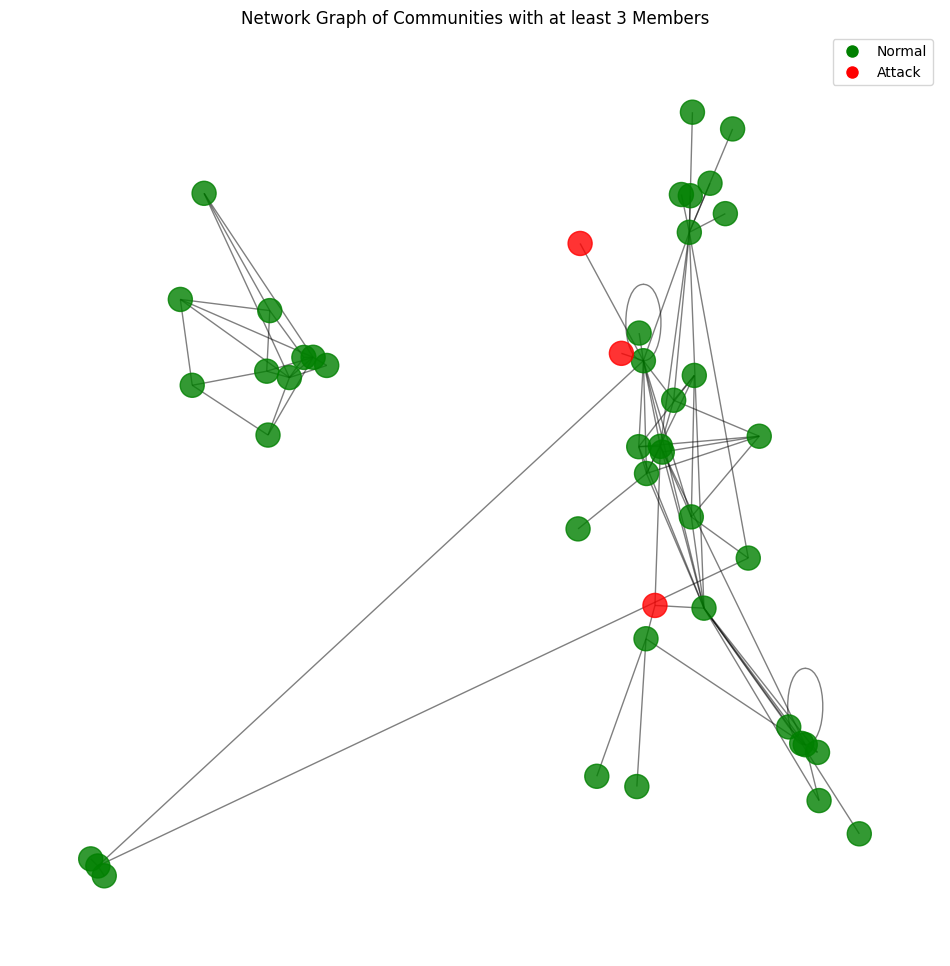

In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from collections import defaultdict
from matplotlib import cm

# Assuming df is your DataFrame

# Initialize an undirected graph
G = nx.Graph()

# Add edges and nodes to the graph, ensuring all nodes have a 'label'
for index, row in df.iterrows():
    # Convert 'Scr_bytes' and 'Des_bytes' to integers, handling non-numeric values
    src_bytes = int(row['Scr_bytes']) if row['Scr_bytes'].isdigit() else 0
    des_bytes = int(row['Des_bytes']) if row['Des_bytes'].isdigit() else 0
    total_bytes = src_bytes + des_bytes

    # Ensure nodes are added with their 'class3' label
    # This assumes all communications (edges) from a source have the same 'class3' label
    if row['Scr_IP'] not in G:
        G.add_node(row['Scr_IP'], label=row['class3'])
    if row['Des_IP'] not in G:
        G.add_node(row['Des_IP'], label='Normal')  # Adjust if destinations can also be 'Attack'

    # Add the edge with the associated attributes
    G.add_edge(
        row['Scr_IP'],
        row['Des_IP'],
        weight=total_bytes,
        protocol=row['Protocol'],
        src_port=row['Scr_port'],
        des_port=row['Des_port'],
        service=row.get('Service', None)
        # label attribute for edges removed since nodes now carry 'class3' labels
    )

# Detect communities using the Louvain method
partition = community_louvain.best_partition(G, weight='weight')

# Filter the partition to only include communities with at least 3 members
community_sizes = defaultdict(int)
for node, community in partition.items():
    community_sizes[community] += 1

filtered_nodes = [node for node, community in partition.items() if community_sizes[community] >= 3]
subG = G.subgraph(filtered_nodes)
sub_partition = {node: partition[node] for node in subG.nodes()}

# Visualization
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subG, seed=42)

# Assign colors based on the node label
label_color_map = {
    'Normal': 'green',
    'Attack': 'red'  # Ensure this matches the exact wording in your 'class3' column
}
node_colors = [label_color_map.get(subG.nodes[node]['label'], 'green') for node in subG]  # Default to 'green'

nx.draw_networkx_nodes(subG, pos, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(subG, pos, alpha=0.5)

# Create legend for node labels
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) 
                   for label, color in label_color_map.items()]
plt.legend(handles=legend_elements, loc='best')

plt.title('Network Graph of Communities with at least 3 Members')
plt.axis('off')
plt.show()


In [19]:
from collections import Counter

# Calculate the size of each community
community_sizes = Counter(partition.values())

# Count how many communities have the same size
size_counts = Counter(community_sizes.values())

# Display the number of communities for each size
for size, count in size_counts.items():
    print(f"There are {count} communities with {size} members.")

There are 71 communities with 1 members.
There are 1 communities with 6 members.
There are 1 communities with 19 members.
There are 1 communities with 3 members.
There are 1 communities with 7 members.
There are 1 communities with 10 members.


In [20]:
from collections import defaultdict, Counter

# Assuming 'partition' is already computed

# Initialize a dictionary to hold the label counts for each community
community_label_counts = defaultdict(lambda: Counter())

# Populate the community_label_counts with label counts for each community
for node, community in partition.items():
    node_label = G.nodes[node]['label']  # Now we're sure 'label' is set for all nodes
    community_label_counts[community][node_label] += 1

# Calculate the size of each community and their label distribution
for community, label_counts in community_label_counts.items():
    community_size = sum(label_counts.values())
    print(f"Community {community} has {community_size} members.")
    for label, count in label_counts.items():
        print(f" - {count} members with label '{label}'")


Community 0 has 1 members.
 - 1 members with label 'Attack'
Community 1 has 6 members.
 - 6 members with label 'Normal'
Community 6 has 19 members.
 - 16 members with label 'Normal'
 - 3 members with label 'Attack'
Community 3 has 3 members.
 - 3 members with label 'Normal'
Community 5 has 7 members.
 - 7 members with label 'Normal'
Community 7 has 1 members.
 - 1 members with label 'Normal'
Community 8 has 1 members.
 - 1 members with label 'Normal'
Community 9 has 1 members.
 - 1 members with label 'Normal'
Community 10 has 1 members.
 - 1 members with label 'Attack'
Community 12 has 1 members.
 - 1 members with label 'Normal'
Community 13 has 1 members.
 - 1 members with label 'Normal'
Community 14 has 10 members.
 - 10 members with label 'Normal'
Community 15 has 1 members.
 - 1 members with label 'Normal'
Community 16 has 1 members.
 - 1 members with label 'Normal'
Community 17 has 1 members.
 - 1 members with label 'Normal'
Community 18 has 1 members.
 - 1 members with label 'Nor

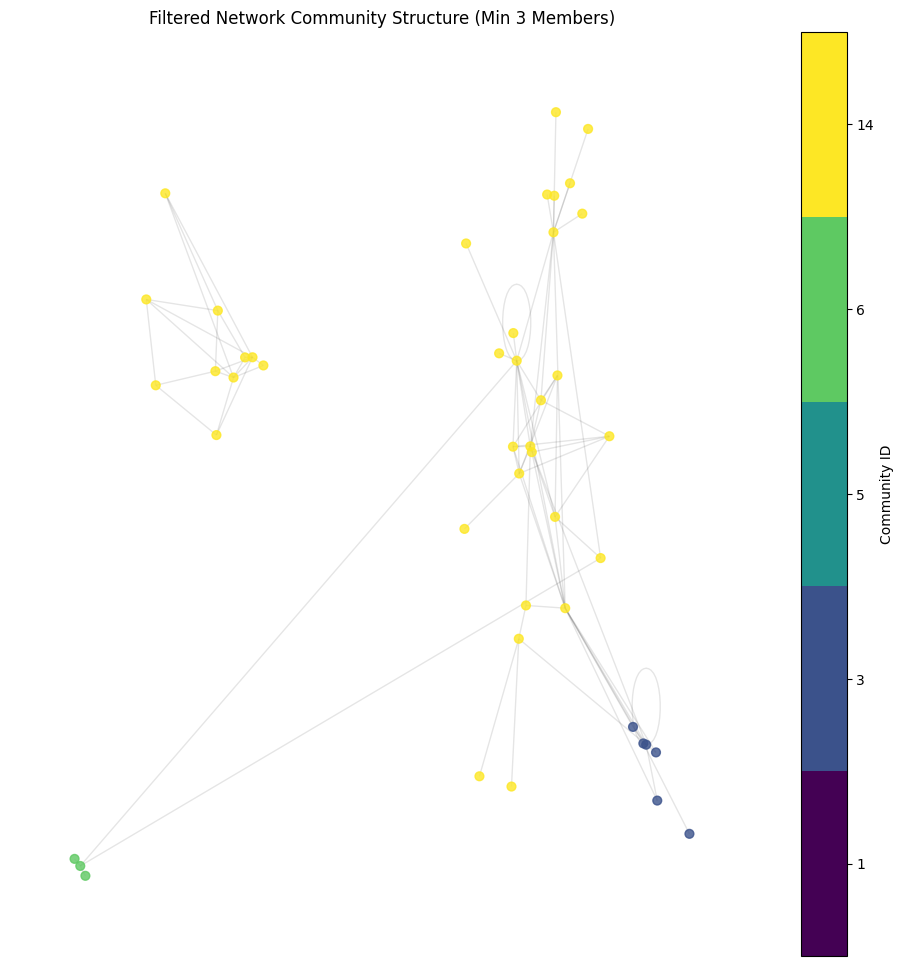

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Assuming 'subG' and 'sub_partition' are defined from your community detection

# Create a figure and a subplot with axes
fig, ax = plt.subplots(figsize=(12, 12))

# Generate layout
pos = nx.spring_layout(subG, seed=42)

# Determine the number of unique communities for color mapping
num_communities = len(set(sub_partition.values()))
cmap = plt.get_cmap('viridis', num_communities)

# Draw the nodes, color-coded by their community membership
node_colors = [cmap(sub_partition[node]) for node in subG.nodes()]
nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=40, alpha=0.8, ax=ax)

# Draw the edges with low opacity
nx.draw_networkx_edges(subG, pos, alpha=0.1, ax=ax)

# Create a colorbar
norm = Normalize(vmin=0, vmax=num_communities-1)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
# Here we specify the 'ax' argument to ensure the colorbar knows where to go
cbar = plt.colorbar(sm, ax=ax, ticks=range(num_communities), 
                    boundaries=np.arange(-0.5, num_communities + 0.5, 1), 
                    spacing='proportional', label='Community ID')

# Adjust colorbar ticks to show community IDs if they are not sequential numbers starting from 0
community_ids = list(set(sub_partition.values()))
community_ids.sort()
cbar.set_ticklabels(community_ids)

plt.title("Filtered Network Community Structure (Min 3 Members)")
plt.axis('off')  # Turn off the axis
plt.show()


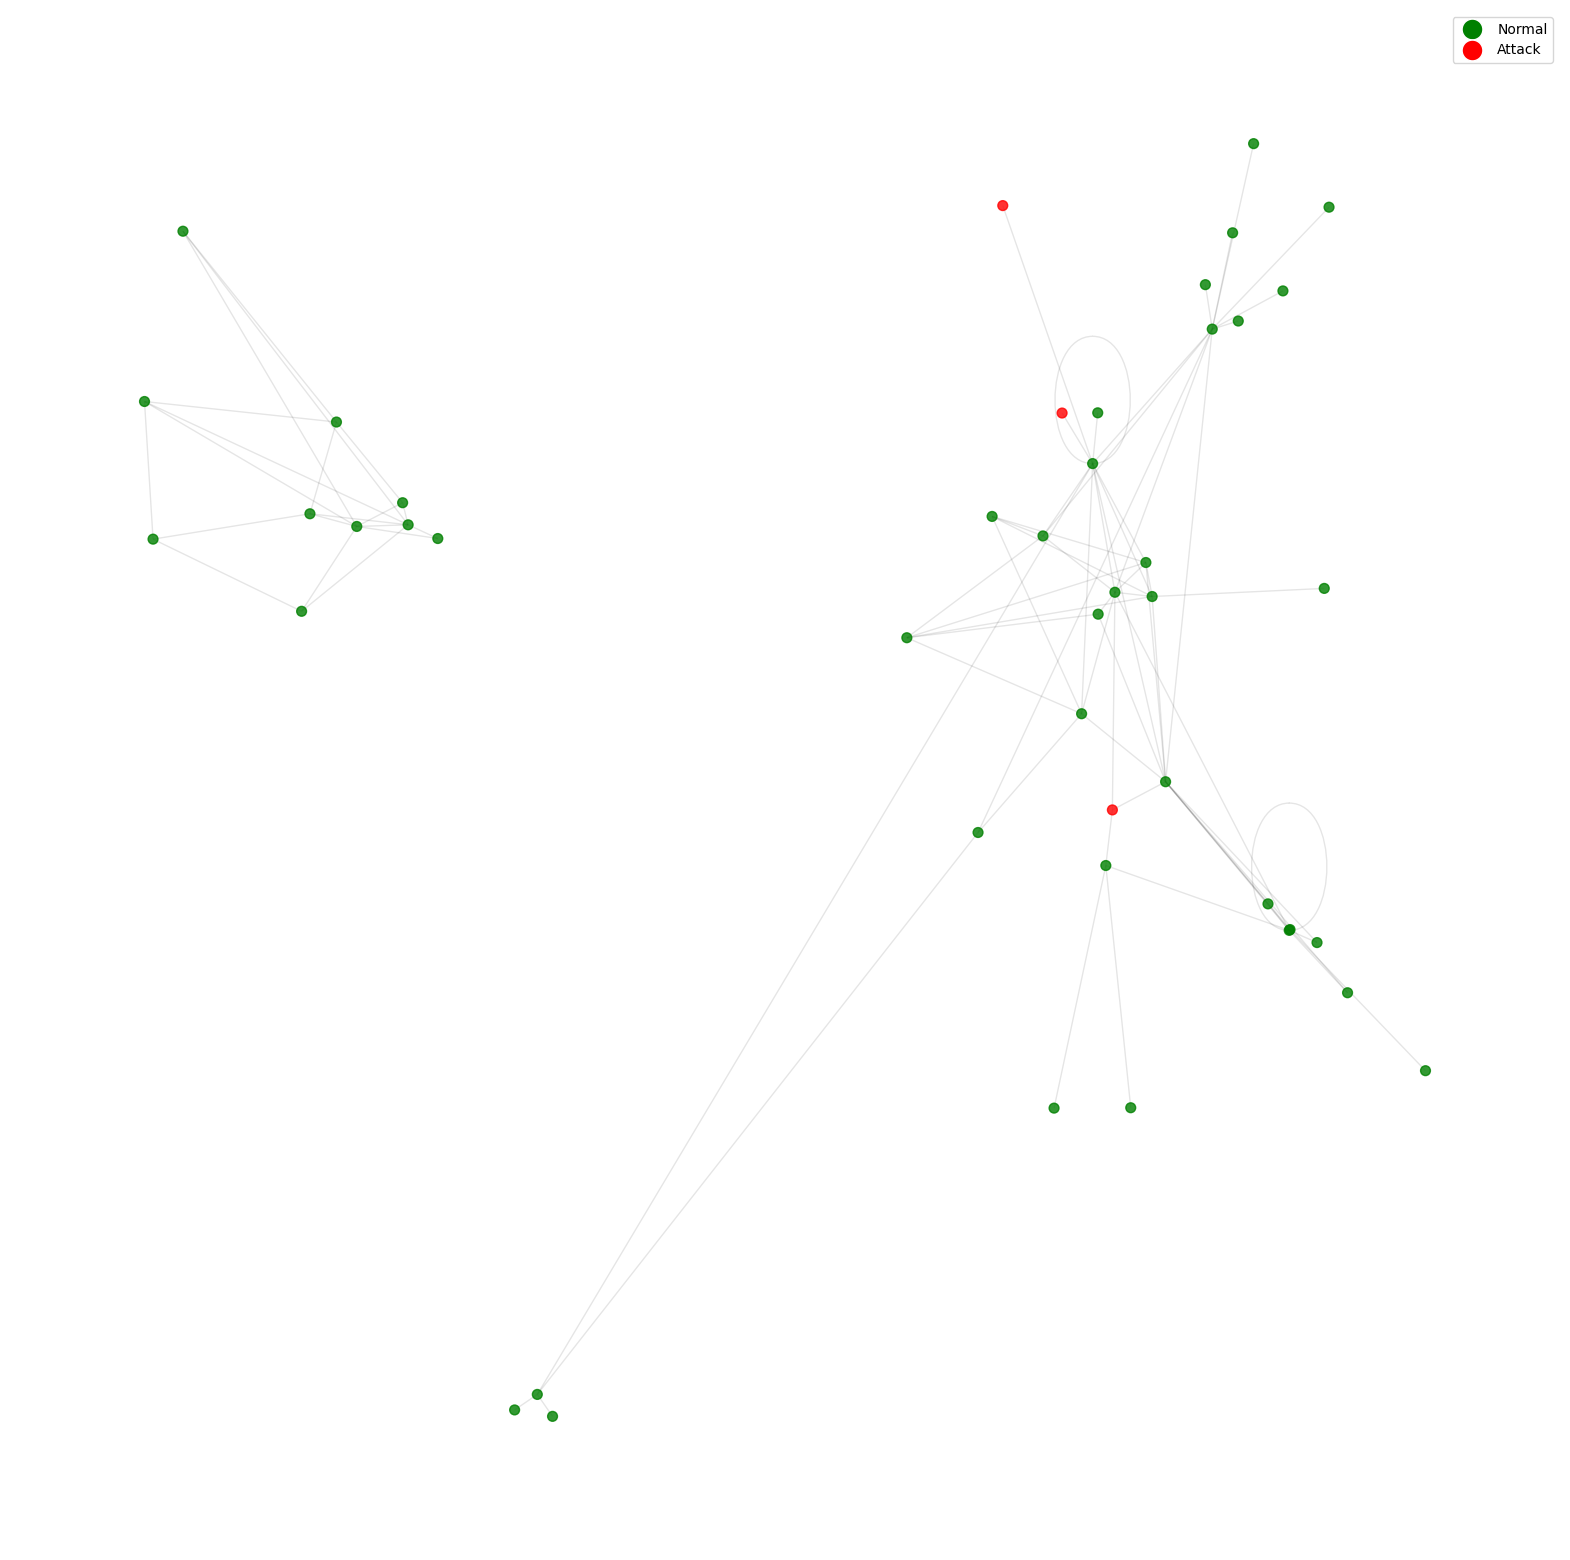

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# Assuming 'subG' is your subgraph, 'partition' is the community assignment dictionary,
# and each node in 'subG' has an attribute 'label' indicating its traffic type.

# Create a mapping of labels to colors
label_color_map = {
    'Normal': 'green',  # Benign traffic in green
    'Attack': 'red',
    # Add more colors if you have more labels
}

# Create the subgraph visualization with a larger figure size for better clarity
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed

# Adjust the spring layout parameters to increase space between nodes
# The 'k' parameter controls the distance between non-connected nodes
pos = nx.spring_layout(subG, k=0.3, iterations=100, seed=42)

# Color the nodes based on their label
node_colors = [label_color_map[subG.nodes[node]['label']] for node in subG.nodes()]

# Draw the nodes with a specified size that's smaller to reduce overlap
nx.draw_networkx_nodes(subG, pos, node_color=node_colors, alpha=0.8, node_size=50)

# Draw the edges with lower opacity to reduce visual clutter
nx.draw_networkx_edges(subG, pos, alpha=0.1)

# Create a legend for the node colors
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=15)
                   for label, color in label_color_map.items()]
plt.legend(handles=legend_elements, loc='best')

plt.axis('off')  # Turn off the axis
plt.show()


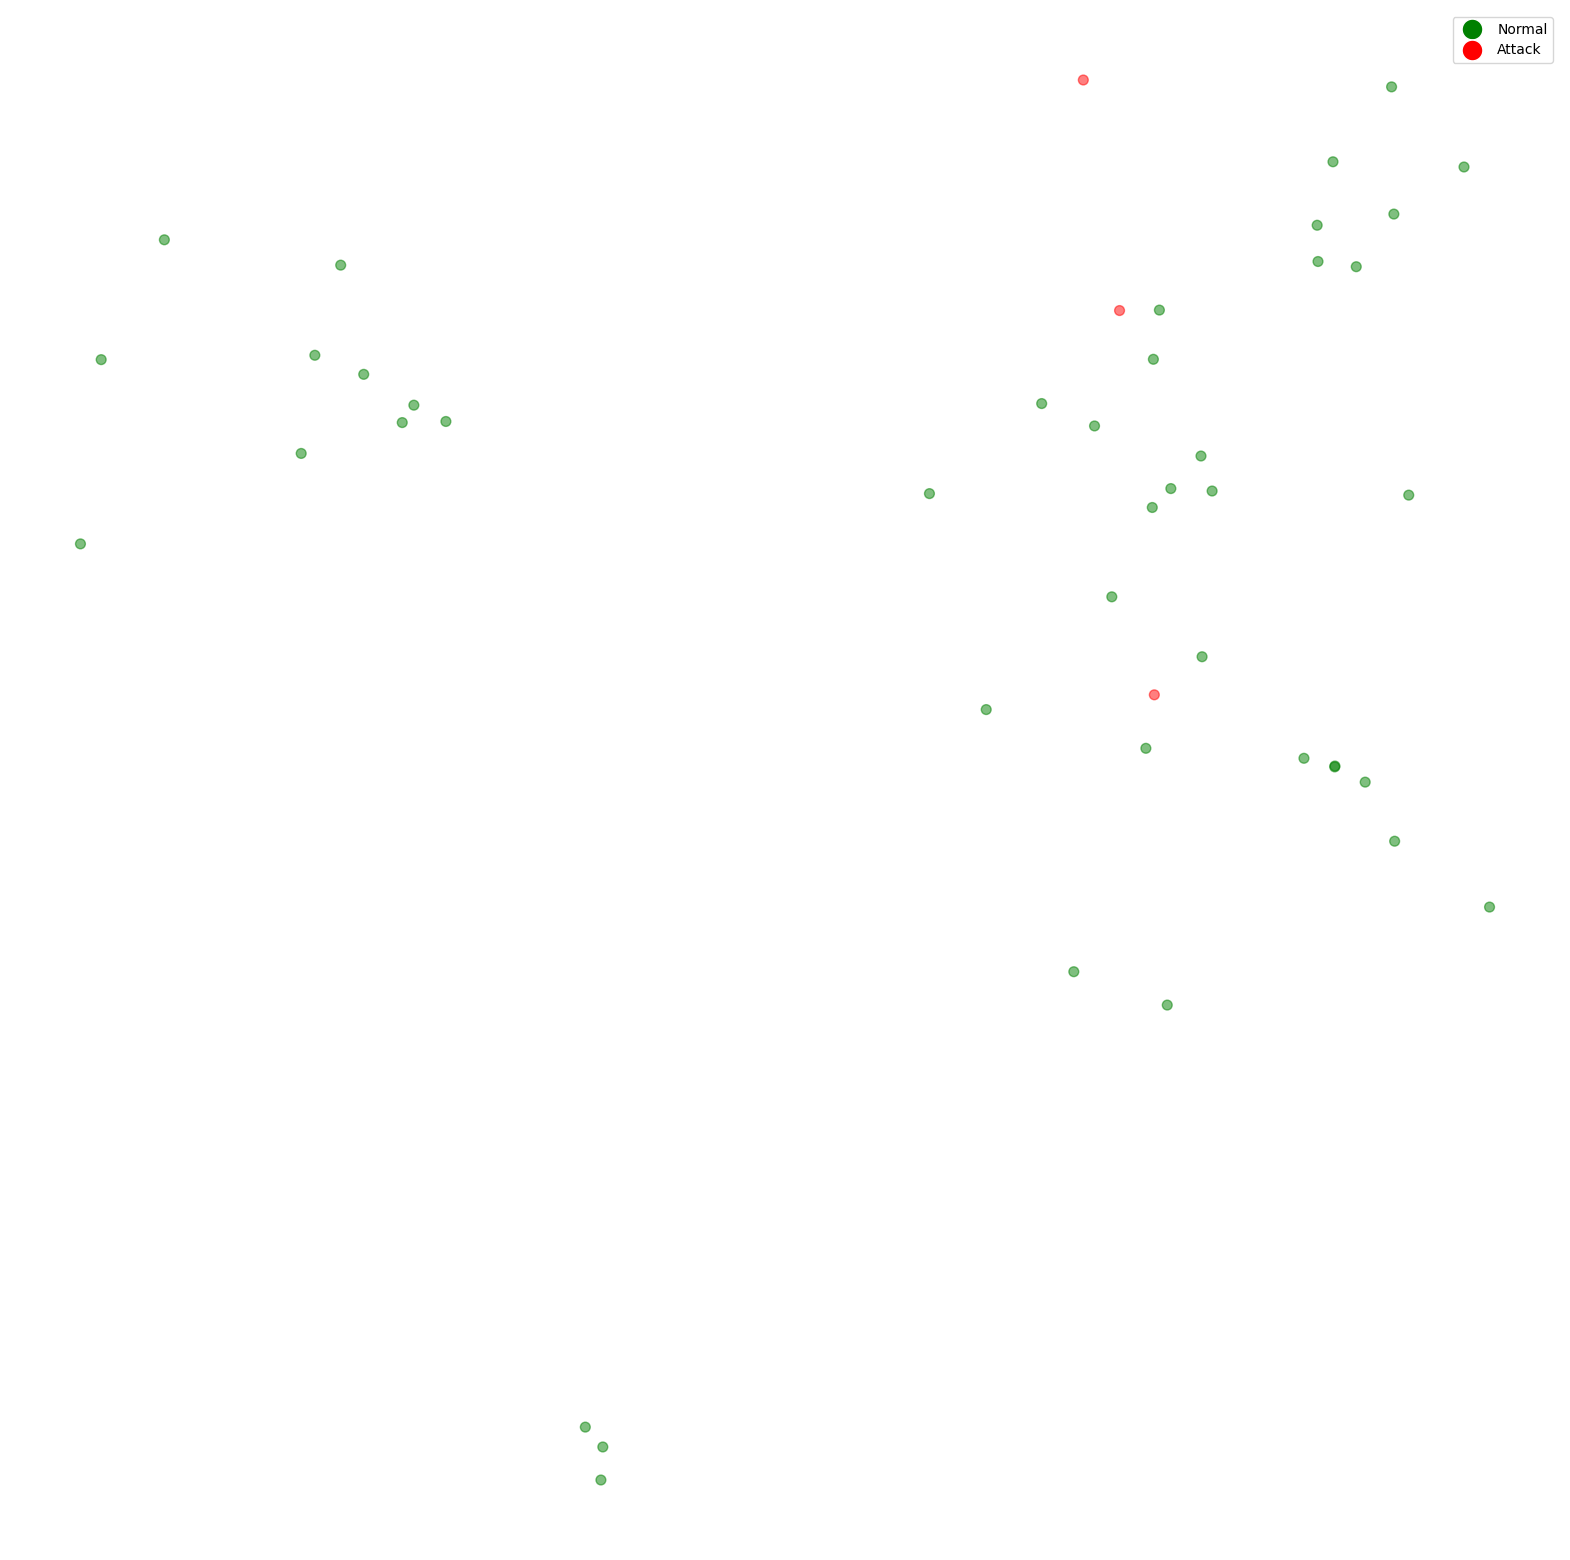

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming 'subG' is your subgraph and you've defined 'label_color_map'

# Increase figure size for better clarity
plt.figure(figsize=(20, 20))

# Further adjust the spring layout parameters
pos = nx.spring_layout(subG, k=0.5, iterations=100, seed=42)  # Increase k for more space

# Draw the nodes with transparency (alpha value)
node_colors = [label_color_map[subG.nodes[node]['label']] for node in subG.nodes()]
nx.draw_networkx_nodes(subG, pos, node_color=node_colors, alpha=0.5, node_size=50)

# Optionally, draw edges with very low opacity or skip this step to remove edges
# nx.draw_networkx_edges(subG, pos, alpha=0.05)

# Add legend for node labels
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=15)
                   for label, color in label_color_map.items()]
plt.legend(handles=legend_elements, loc='best')

plt.axis('off')  # Turn off the axis
plt.show()


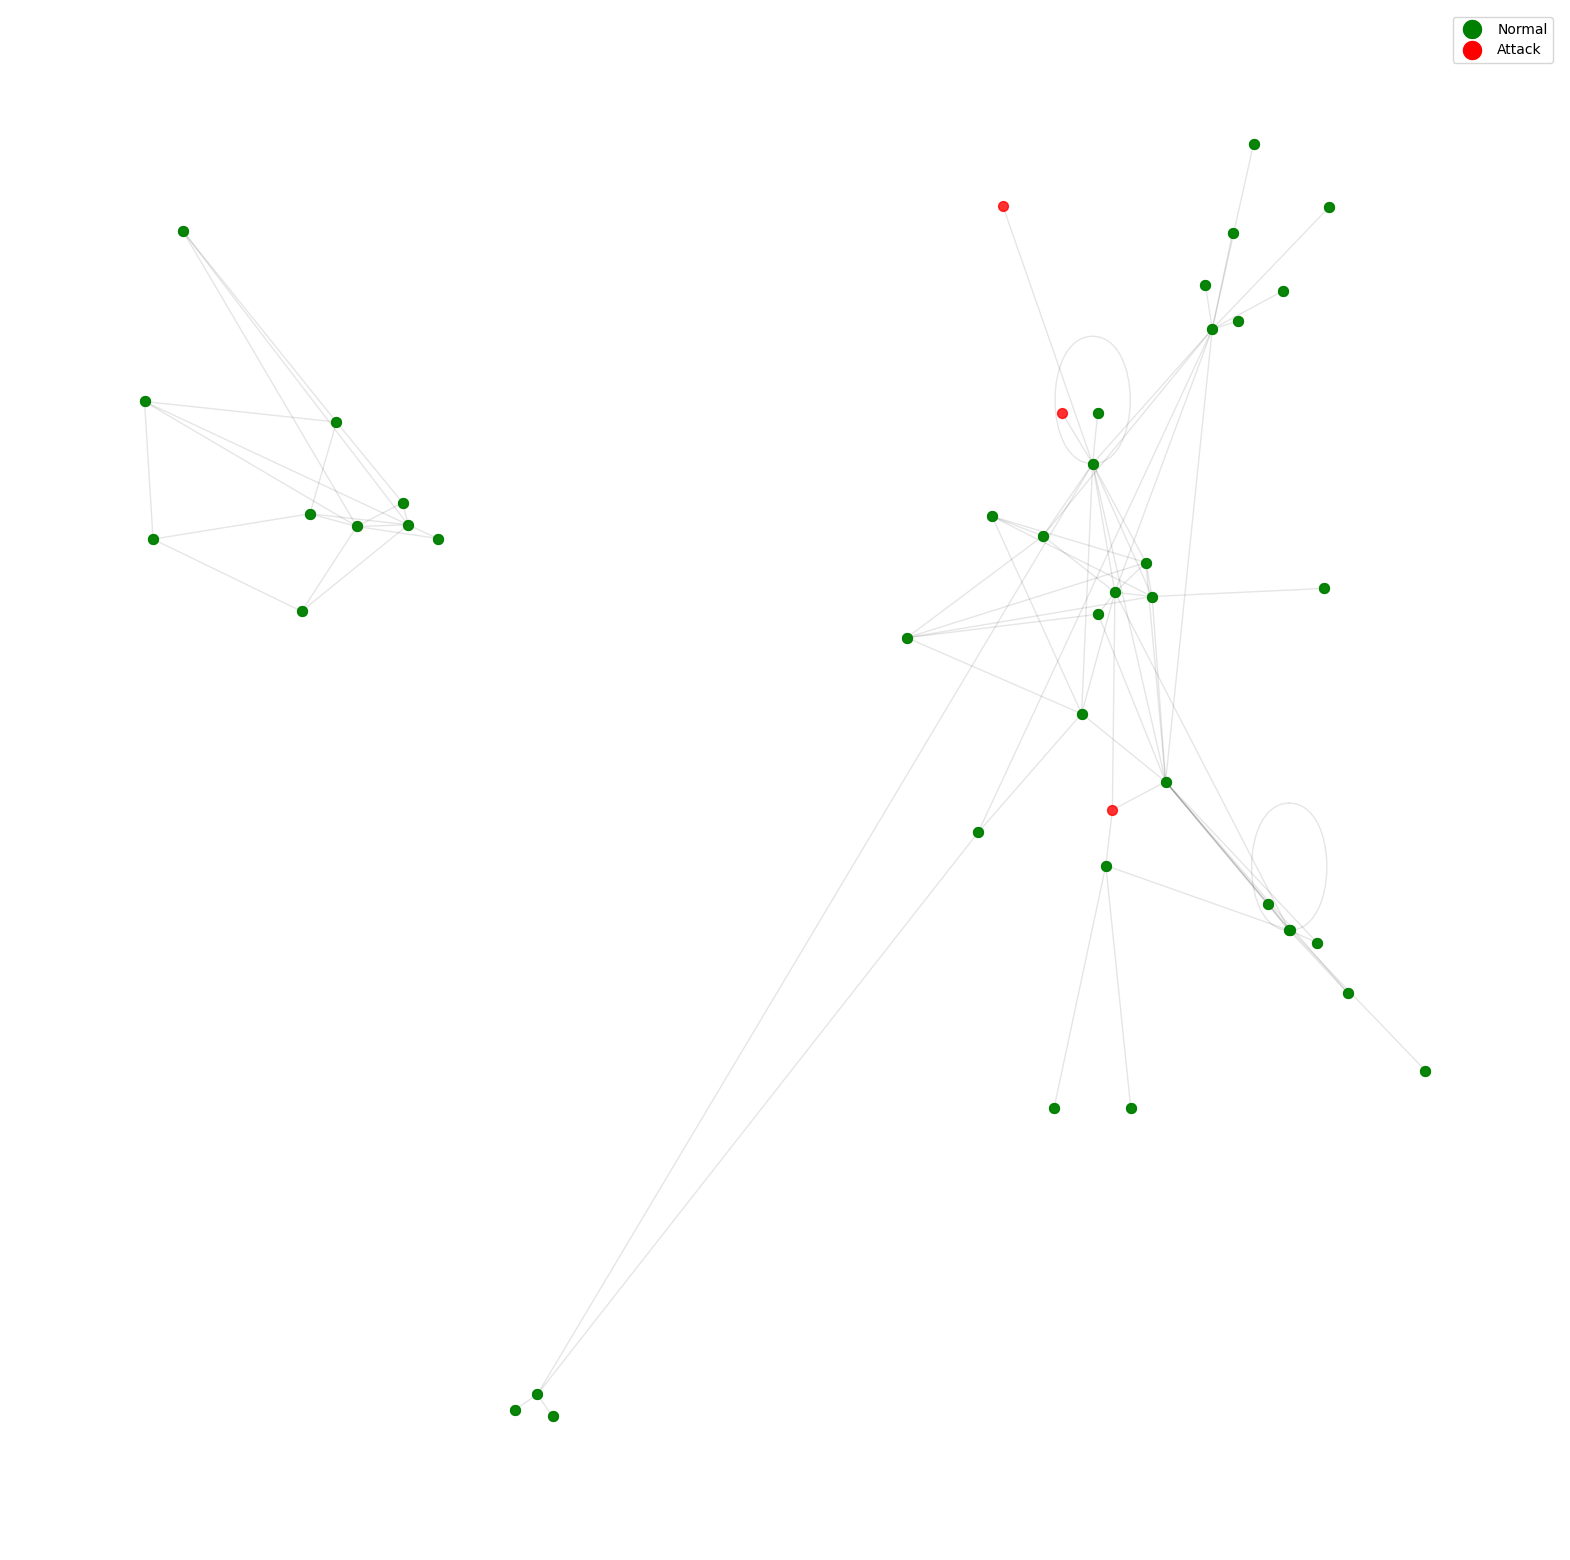

In [26]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming 'subG' is your subgraph and you've defined 'label_color_map'

# Increase figure size for better clarity
plt.figure(figsize=(20, 20))

# Adjust the spring layout parameters
pos = nx.spring_layout(subG, k=0.3, iterations=100, seed=42)

# Draw the benign nodes first
benign_nodes = [node for node in subG.nodes() if subG.nodes[node]['label'] == 'Normal']
nx.draw_networkx_nodes(subG, pos, nodelist=benign_nodes, node_color='green', alpha=0.8, node_size=50)

# Then draw the attack nodes on top of the benign nodes
for label, color in label_color_map.items():
    if label != 'BENIGN':  # We already drew the benign nodes
        attack_nodes = [node for node in subG.nodes() if subG.nodes[node]['label'] == label]
        nx.draw_networkx_nodes(subG, pos, nodelist=attack_nodes, node_color=color, alpha=0.8, node_size=50)

# Draw the edges with low opacity
nx.draw_networkx_edges(subG, pos, alpha=0.1)

# Create a legend for the colors
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=15)
                   for label, color in label_color_map.items()]
plt.legend(handles=legend_elements, loc='best')

plt.axis('off')  # Turn off the axis
plt.show()


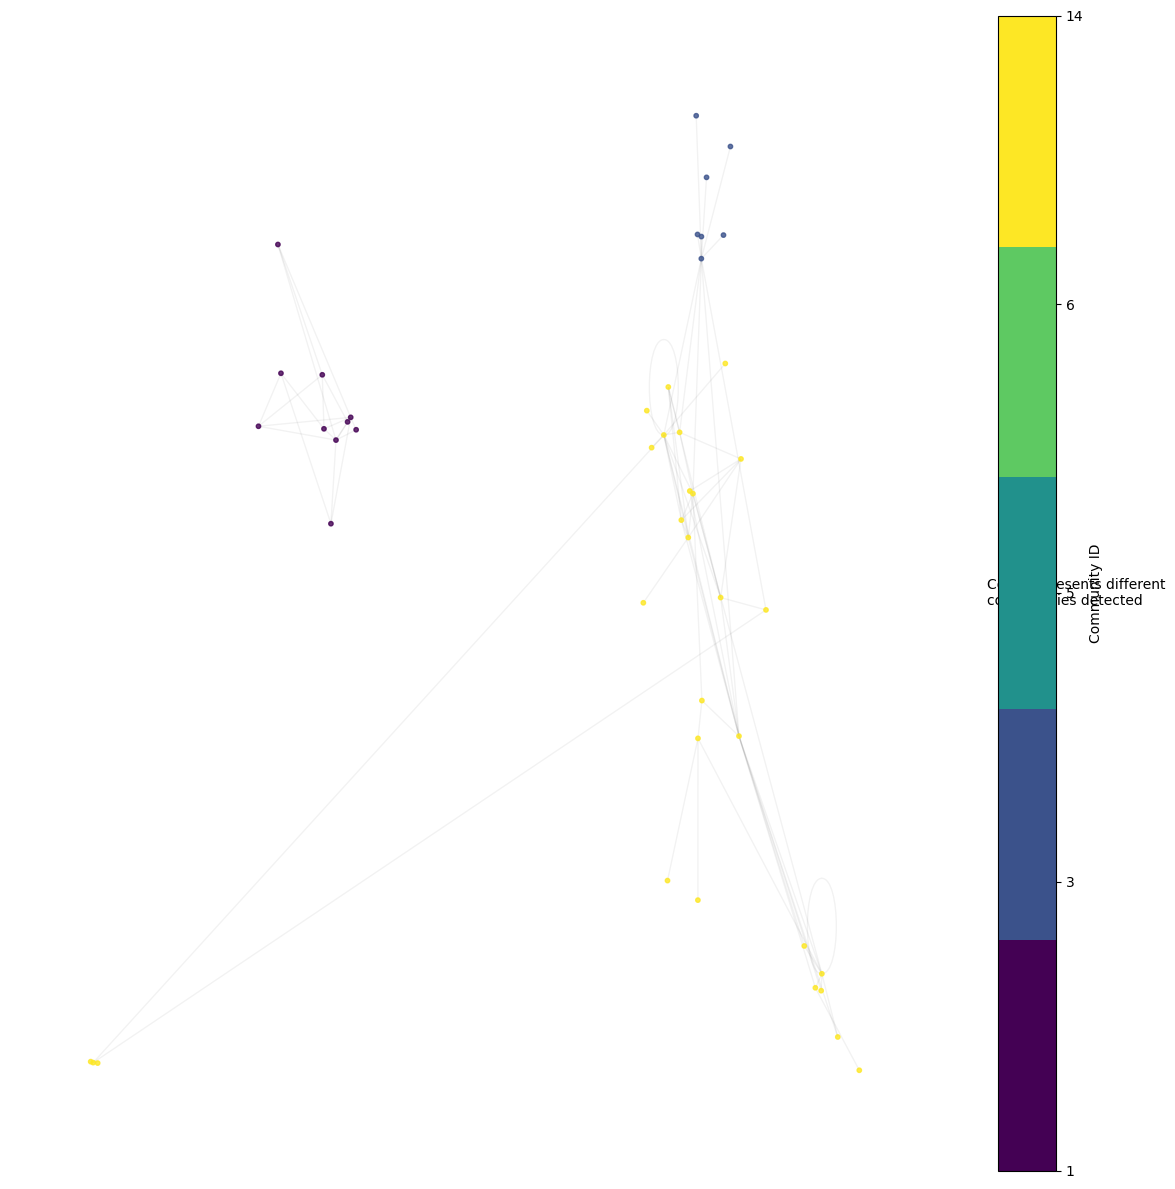

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Assuming 'subG' is your subgraph and 'sub_partition' is the partition dictionary for the subgraph

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 15))

# Use the spring layout with specific parameters to spread nodes further apart
pos = nx.spring_layout(subG, k=0.1, iterations=50, seed=42)

# Determine the number of unique communities for color mapping
num_communities = len(set(sub_partition.values()))
cmap = plt.get_cmap('viridis', num_communities)

# Prepare node colors based on their community membership
node_colors = [cmap(list(sub_partition.values()).index(sub_partition[node]) / (num_communities - 1)) for node in subG]

# Draw the nodes with colors based on their community
nodes = nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=10, alpha=0.8, ax=ax)

# Draw the edges with very low opacity
nx.draw_networkx_edges(subG, pos, alpha=0.05, ax=ax)

# Create a colorbar
norm = Normalize(vmin=0, vmax=num_communities-1)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(range(num_communities))
cbar = plt.colorbar(sm, ax=ax, spacing='proportional', ticks=range(num_communities), label='Community ID')

# Adjust colorbar ticks to show community IDs if they are not sequential numbers starting from 0
community_ids = list(set(sub_partition.values()))
community_ids.sort()
cbar.set_ticklabels(community_ids)

# Add text annotation to explain the color scheme
plt.text(1.05, 0.5, 'Color represents different\ncommunities detected', transform=ax.transAxes, ha='left', va='center')

# Turn off the axis
ax.axis('off')

# Show the plot
plt.show()



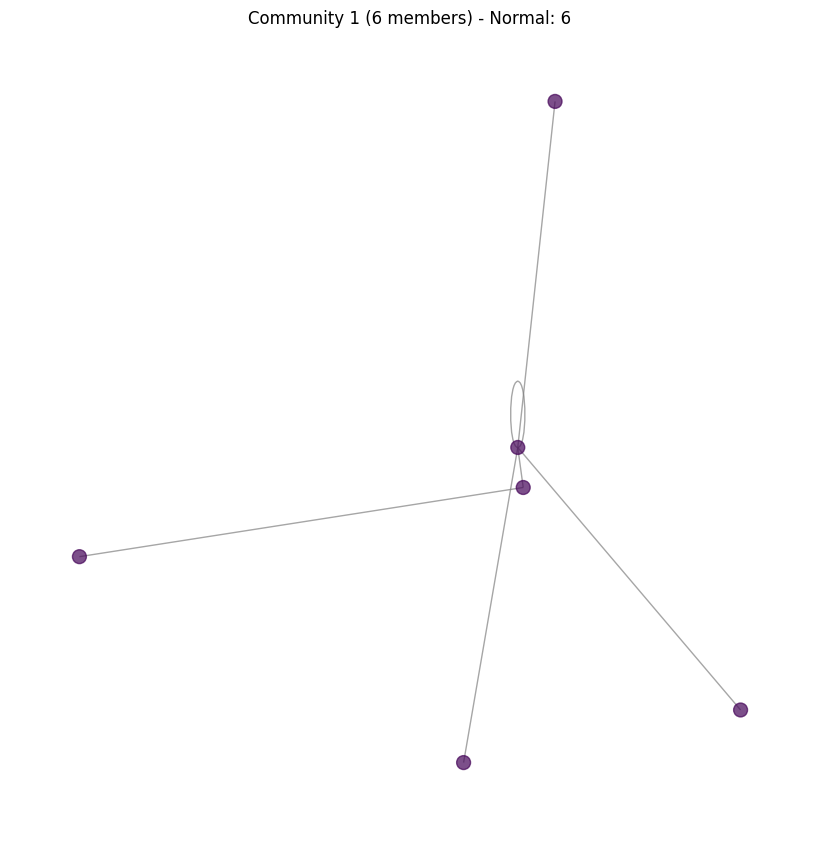

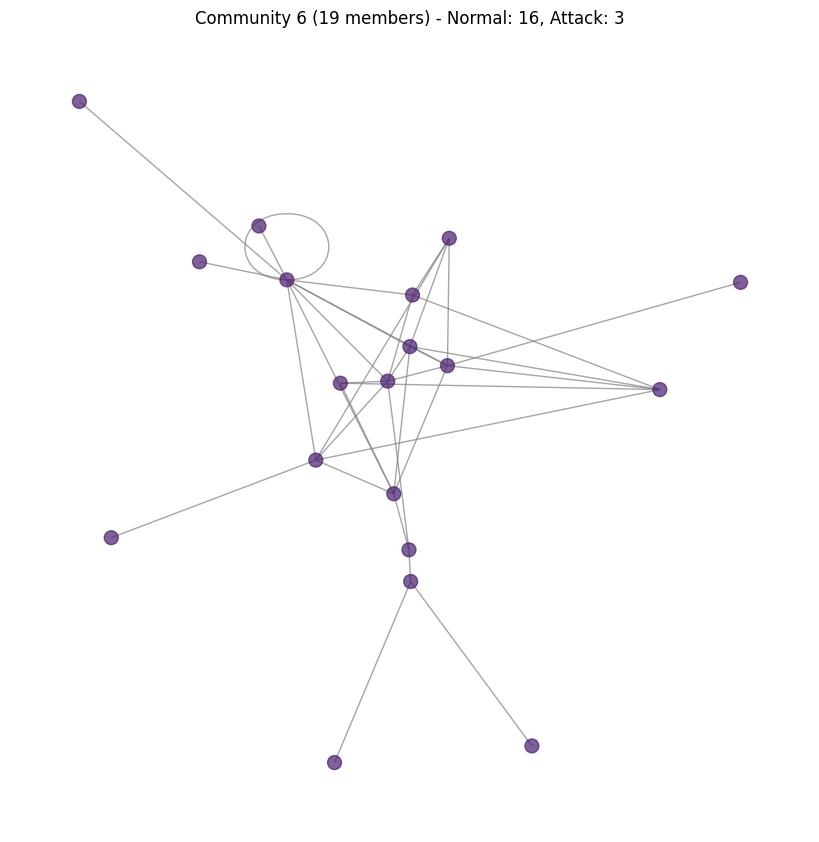

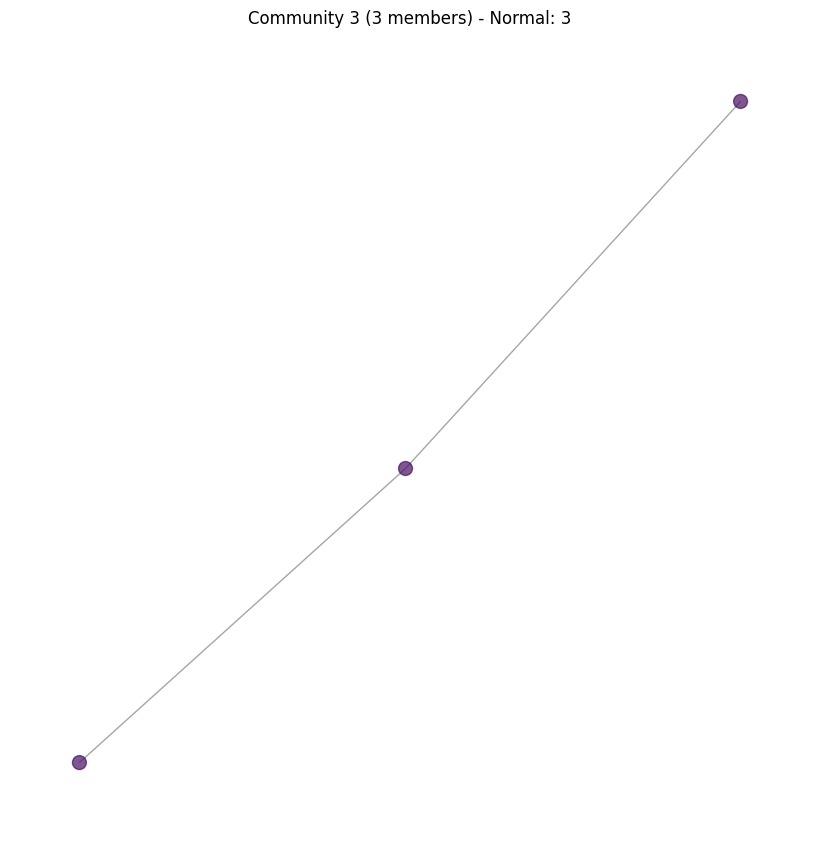

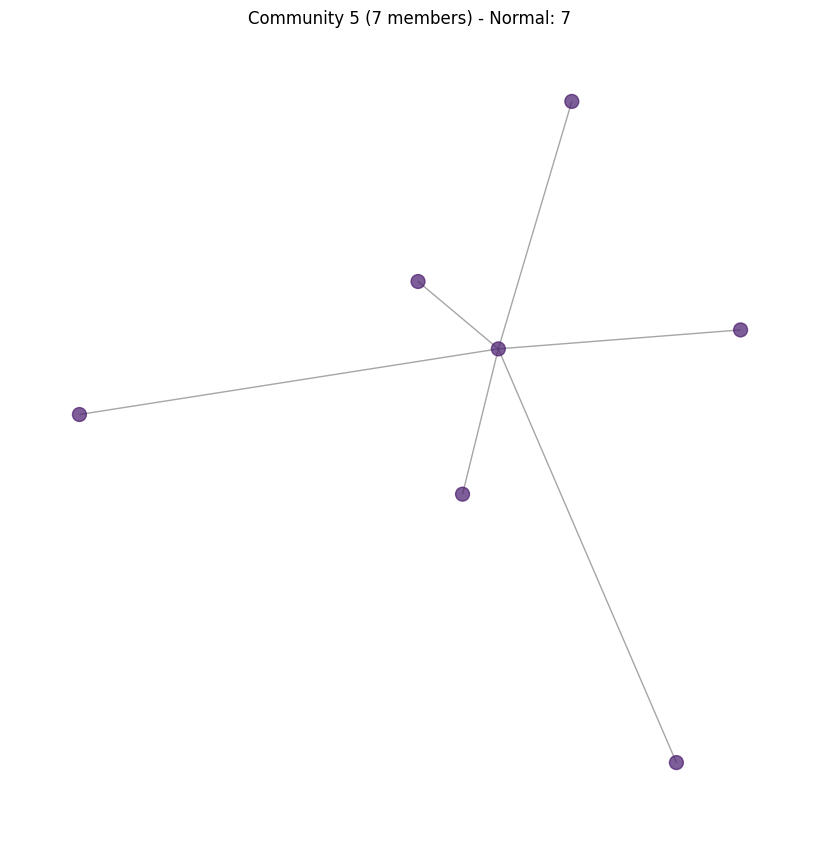

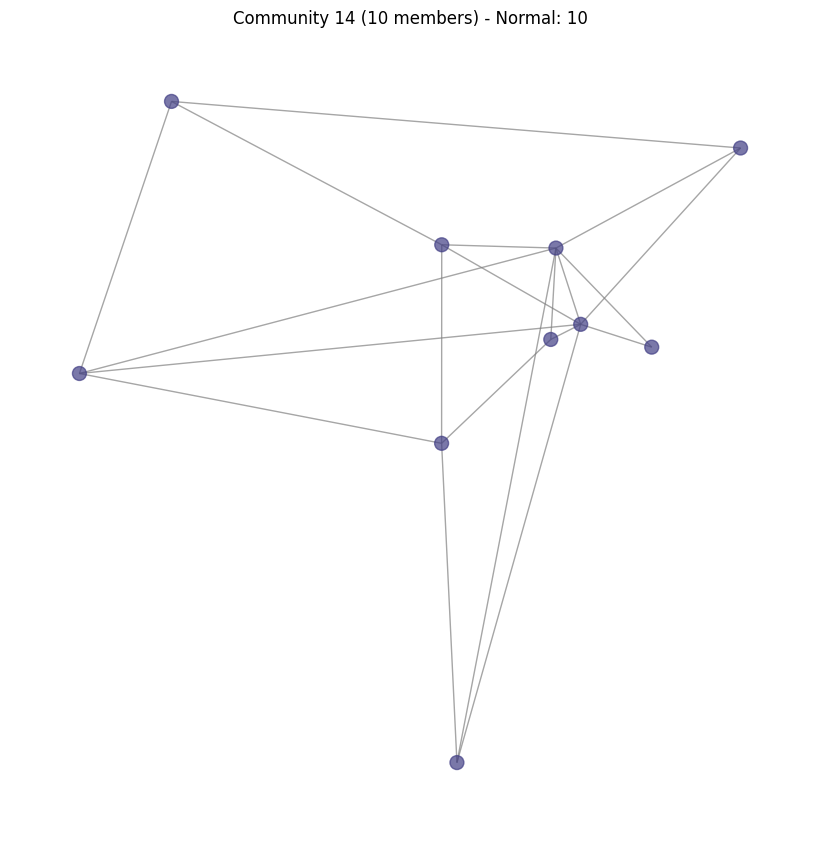

In [28]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict, Counter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import numpy as np
from matplotlib.patches import Patch

# Assuming 'G' is your original graph, 'partition' maps nodes to communities,
# and each node in 'G' has a 'label' attribute indicating traffic type.

# Calculate the community sizes and label distributions
community_sizes = defaultdict(int)
community_labels = defaultdict(lambda: Counter())

for node, community in partition.items():
    community_sizes[community] += 1
    node_label = G.nodes[node]['label']
    community_labels[community][node_label] += 1

# Filter out communities with less than 3 members
eligible_communities = [community for community, size in community_sizes.items() if size >= 3]

# Determine the number of unique communities for color mapping
num_communities = len(set(partition.values()))
cmap = plt.get_cmap('viridis', num_communities)
norm = Normalize(vmin=0, vmax=num_communities-1)
sm = ScalarMappable(norm=norm, cmap=cmap)

# Create and visualize a subgraph for each eligible community
for community_id in eligible_communities:
    community_nodes = [node for node in G if partition[node] == community_id]
    community_subgraph = G.subgraph(community_nodes)
    pos = nx.spring_layout(community_subgraph, seed=42)
    plt.figure(figsize=(8, 8))
    node_colors = [sm.to_rgba(community_id) for node in community_subgraph]
    nx.draw(community_subgraph, pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', alpha=0.7)
    
    # Summarize label information for the community
    label_summary = ", ".join([f"{label}: {count}" for label, count in community_labels[community_id].items()])
    
    plt.title(f'Community {community_id} ({community_sizes[community_id]} members) - {label_summary}')
    plt.axis('off')
    plt.show()


